# FastAI Cookbook Ch.3.1. Training a model with tabular datasets in fast.ai
>Example of training a model with a tabular dataset in fast.ai The example shown here is adapted from the paper by [Howard and Gugger](https://arxiv.org/pdf/2002.04688.pdf)

- toc:true
- branch: master
- badges: true
- comments: true
- author: Mark Ryan
- categories: [fastai, cookbook, tabular]

# Prepare the notebook and ingest the dataset
The first section of this notebook is identical to the chapter 2 notebook for examining tabular curated datasets: https://github.com/PacktPublishing/Deep-Learning-with-fastai-Cookbook/blob/main/ch2/examining_tabular_datasets.ipynb

In [2]:
# imports for notebook boilerplate
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.tabular.all import *


     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 35.8 MB/s 
     |████████████████████████████████| 48 kB 4.4 MB/s 
     |████████████████████████████████| 189 kB 44.6 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 51 kB 303 kB/s 
     |████████████████████████████████| 561 kB 38.6 MB/s 
     |████████████████████████████████| 130 kB 45.8 MB/s 


In [3]:
# set up the notebook for fast.ai
fastbook.setup_book()

Mounted at /content/gdrive


In [4]:
# ingest the curated tabular dataset ADULT_SAMPLE
path = untar_data(URLs.ADULT_SAMPLE)

In [5]:
# examine the directory structure
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/export.pkl'),Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/models')]

In [6]:
# ingest the dataset into a Pandas dataframe
df = pd.read_csv(path/'adult.csv')

In [7]:
# examine the first few records in the dataframe
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [8]:
# get the number of records in the dataset
df.shape

(32561, 15)

In [9]:
# get the count of unique values in each column of the dataset
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
salary                2
dtype: int64

In [10]:
# count the number of missing values in each column of the dataset
df.isnull().sum()

age                 0
workclass           0
fnlwgt              0
education           0
education-num     487
marital-status      0
occupation        512
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country      0
salary              0
dtype: int64

In [11]:
# get the subset of the dataset where age <= 40
# streetcarjan2014[streetcarjan2014.Location == "King and Shaw"].Route
df_young = df[df.age <= 40]
df_young.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
5,20,Private,63210,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,15,United-States,<50k
7,37,Private,138940,11th,7.0,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<50k
9,36,Self-emp-inc,216711,HS-grad,NaN,Married-civ-spouse,NaN,Husband,White,Male,99999,0,50,?,>=50k


# Define transforms, dependent variable, continuous and categorical columns
In this section we defined the transforms that will be applied to the dataset along with the target, continuous and categorical columns

In [12]:
# define transforms to apply to the tabular dataset
procs = [FillMissing,Categorify]
# define the dependent variable (y value)
dep_var = 'salary'
# define columns that are continuous / categorical
cont,cat = cont_cat_split(df, 1, dep_var=dep_var) 

In [13]:
cont

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [14]:
cat

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

# Define TabularDataLoaders object

In [15]:
# define TabularDataLoaders object
# valid_idx: the indices to use for the validation set
dls=TabularDataLoaders.from_df(df,path,procs= procs, 
                               cat_names= cat, cont_names = cont, y_names = dep_var, valid_idx=list(range(1024,1260)), bs=64)
                               

In [16]:
# use show_batch() to see a sample batch including x and y values
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary
0,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,Male,Portugal,False,22.0,162667.0,9.0,0.0,0.0,50.0,<50k
1,Local-gov,HS-grad,Divorced,Protective-serv,Unmarried,White,Female,United-States,False,43.0,186995.0,9.0,0.0,0.0,40.0,<50k
2,Self-emp-not-inc,Some-college,Never-married,Craft-repair,Not-in-family,White,Female,United-States,False,18.0,42857.0,10.0,0.0,0.0,35.0,<50k
3,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male,United-States,False,40.0,209040.0,9.0,0.0,0.0,40.0,<50k
4,Private,Bachelors,Divorced,Adm-clerical,Not-in-family,White,Female,United-States,False,50.0,77905.0,13.0,0.0,0.0,8.0,<50k
5,?,Prof-school,Married-civ-spouse,?,Husband,White,Male,United-States,False,63.0,247986.0,15.0,0.0,0.0,30.0,>=50k
6,Private,12th,Never-married,Sales,Own-child,Black,Female,United-States,False,18.0,311795.0,8.0,0.0,0.0,20.0,<50k
7,Local-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,False,43.0,174395.0,14.0,0.0,0.0,50.0,<50k
8,Self-emp-inc,HS-grad,Never-married,Sales,Not-in-family,White,Male,United-States,False,58.0,190541.0,9.0,0.0,0.0,47.0,<50k
9,Private,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,?,False,34.0,609789.0,9.0,0.0,0.0,30.0,<50k


# Define and train model

In [17]:
%%time
learn = tabular_learner(dls,layers=[200,100], metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.341057,0.362043,0.817797,00:07
1,0.327887,0.337167,0.843220,00:06
2,0.305436,0.336424,0.847458,00:07


CPU times: user 22.7 s, sys: 1.37 s, total: 24.1 s
Wall time: 31.1 s


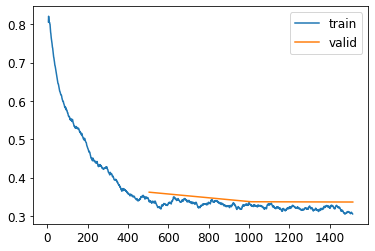

In [18]:
learn.recorder.plot_loss()

In [19]:
# show sample result, including transformed x, y and predicted transformed y
learn.show_results()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,salary_pred
0,7.0,12.0,3.0,13.0,1.0,5.0,2.0,40.0,1.0,58.0,248841.0,9.0,15024.0,0.0,40.0,1.0,1.0
1,8.0,11.0,3.0,11.0,1.0,5.0,2.0,40.0,1.0,41.0,309056.0,16.0,0.0,0.0,50.0,1.0,1.0
2,5.0,5.0,7.0,9.0,3.0,2.0,1.0,31.0,1.0,63.0,106910.0,3.0,0.0,0.0,19.0,0.0,0.0
3,1.0,11.0,3.0,1.0,1.0,5.0,2.0,40.0,1.0,72.0,118902.0,16.0,0.0,2392.0,6.0,1.0,1.0
4,5.0,2.0,5.0,7.0,3.0,3.0,1.0,40.0,1.0,41.0,155657.0,7.0,0.0,0.0,40.0,0.0,0.0
5,5.0,2.0,1.0,8.0,2.0,5.0,2.0,40.0,1.0,38.0,252250.0,7.0,0.0,0.0,65.0,0.0,0.0
6,5.0,16.0,5.0,15.0,5.0,5.0,2.0,40.0,1.0,29.0,277342.0,10.0,0.0,0.0,40.0,0.0,0.0
7,5.0,12.0,3.0,7.0,1.0,5.0,2.0,40.0,1.0,25.0,218667.0,9.0,0.0,0.0,40.0,0.0,0.0
8,7.0,10.0,1.0,5.0,2.0,5.0,2.0,40.0,1.0,54.0,154785.0,13.0,0.0,0.0,50.0,0.0,0.0


# Examine the structure of the trained model structure

Use the summary() function to see the structure of the trained model, including:

- the layers that make up the model
- total parameters
- loss function
- optimizer function
- callbacks



In [20]:
learn.summary()

TabularModel (Input shape: 64 x 9)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6              
Embedding                                 60         True      
____________________________________________________________________________
                     64 x 8              
Embedding                                 136        True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 40         True      
____________________________________________________________________________
                     64 x 8              
Embedding                                 128        True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 35         True      
_______________________________________________________________

In [22]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(43, 13)
    (8): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=61, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)